In [2]:
import os
import cv2     # for capturing videos
import math 
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import to_categorical
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images

In [3]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


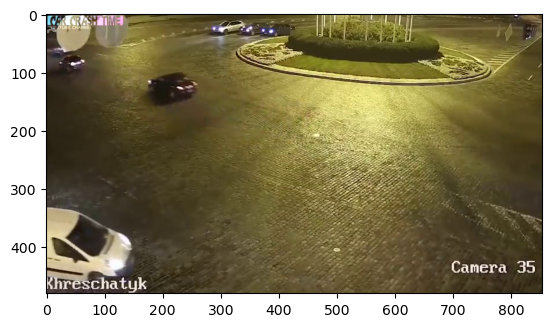

In [5]:
img = plt.imread('95.jpg')   # reading image using its name
plt.imshow(img)

In [6]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [7]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [9]:
y = data.Class
dummy_y = to_categorical(y)

In [10]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [11]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [13]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [15]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [16]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [17]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [18]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,693,186 (98.01 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 462ms/step - accuracy: 0.4749 - loss: 0.8374 - val_accuracy: 0.6119 - val_loss: 0.8887
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.7325 - loss: 0.5364 - val_accuracy: 0.6866 - val_loss: 1.3594
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.8420 - loss: 0.3629 - val_accuracy: 0.7164 - val_loss: 1.1403
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step - accuracy: 0.9472 - loss: 0.1400 - val_accuracy: 0.6866 - val_loss: 1.1858
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.9801 - loss: 0.0922 - val_accuracy: 0.7463 - val_loss: 1.2951
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.9714 - loss: 0.0736 - val_accuracy: 0.7761 - val_loss: 1.2859
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - accuracy: 1.0000 - loss: 0.0398 - val_accuracy: 0.7463 - val_loss: 1.2483
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 0.7612 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.7910 - val_loss: 1.4934
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7910 - val_loss: 1.4949
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7910 - val_loss: 1.4977
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.7910 - val_loss: 1.4994
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7910 - val_loss: 1.5040
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7910 - val_loss: 1.5086
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7910 - val_loss: 1.5117
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8060 - val_lo

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [24]:
test = pd.read_csv('test.csv')

In [25]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [26]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [27]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


(9, 7, 7, 512)

In [28]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [29]:
predictions = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [30]:
print(predictions)

[[5.8044884e-06 9.9999416e-01]
 [2.1458798e-04 9.9978548e-01]
 [2.7276545e-03 9.9727231e-01]
 [8.5014343e-04 9.9914980e-01]
 [2.1651695e-03 9.9783486e-01]
 [3.9432600e-01 6.0567403e-01]
 [7.7013445e-01 2.2986551e-01]
 [6.0134500e-01 3.9865497e-01]
 [8.2611942e-01 1.7388056e-01]]


In [31]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident


In [32]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid = #Enter Your account sid
auth_token = #Enter your auth token
client = Client(account_sid, auth_token)

SyntaxError: invalid syntax (1864300706.py, line 4)

In [35]:
import cv2

cap = cv2.VideoCapture('Accident-1.mp4')
i = 0
flag = 0

while True:
    ret, frame = cap.read()
    
    if ret == True:
        if predictions[int(i/15) % 9][0] < predictions[int(i/15) % 9][1]:
            predict = "No Accident"
        else:
            predict = "Accident"
            flag = 1
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                    predict,
                    (50, 50),
                    font, 1,
                    (0, 255, 255),
                    3,
                    cv2.LINE_4)
        
        cv2.imshow('Frame', frame)
        i = i + 1
        
        # Introduce a delay of 50 milliseconds
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
    else:
        break

# Release the cap object
cap.release()

# Close all windows
cv2.destroyAllWindows()
